##### OBJECTIVE: Building a multi-lingual, multi-label comment clasifier with the help of transformer based model using  XLM-Roberta. Pipelines are defined in below:
###### Data Preparation
##### Dataset Conversion
##### Tokenization
##### Model Setup and Training
##### Threshold Optimization
##### Results and Evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Create the requirements.txt file
requirements = """
numpy
matplotlib
seaborn
pandas
ipykernel
nltk
wordcloud
scikit-learn
langdetect
googletrans==4.0.0rc1
torch
torchvision
torchaudio
transformers
datasets
accelerate
"""

with open("requirements.txt", "w") as f:
    f.write(requirements)

In [ ]:
!pip install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import torch
import numpy as np
from torch.utils.data import WeightedRandomSampler, DataLoader
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding,
    EarlyStoppingCallback, AutoConfig
)
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Load the Data
train_df = pd.read_csv('/content/drive/MyDrive/DATASET/train.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/DATASET/validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DATASET/test.csv')
test_label_df = pd.read_csv('/content/drive/MyDrive/DATASET/test_labels.csv')

Label Distribution:
toxic      2196
abusive     176
vulgar     1275
menace       66
offense    1150
bigotry     193
dtype: int64


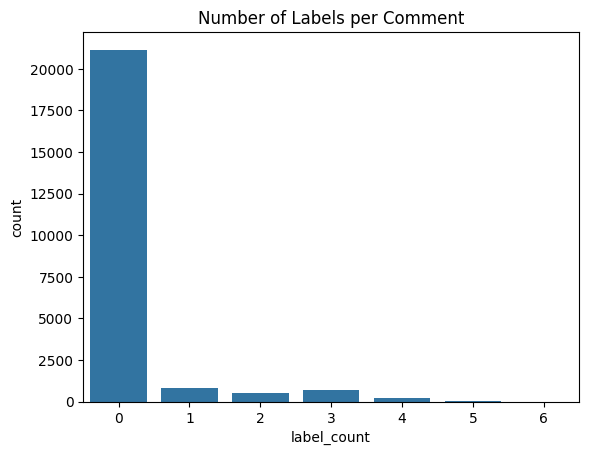

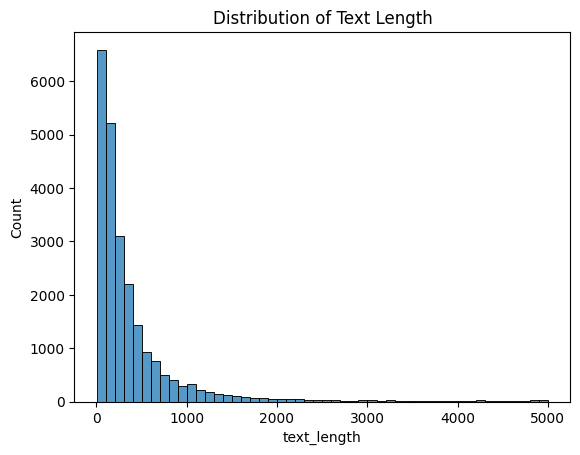

Top Words:
[('the', 66093), ('to', 42513), ('of', 32436), ('and', 30349), ('a', 29825), ('I', 25200), ('is', 24838), ('you', 22561), ('that', 20822), ('in', 19769), ('for', 13880), ('it', 13819), ('"', 12364), ('on', 12345), ('not', 12321), ('be', 12063), ('this', 10772), ('as', 10092), ('have', 9945), ('are', 9824)]


In [ ]:
# Step 2: Exploratory Data Analysis (EDA)
def perform_eda(df):
    label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
    df['label_count'] = df[label_cols].sum(axis=1)
    df['text_length'] = df['feedback_text'].astype(str).apply(len)
    print("Label Distribution:")
    print(df[label_cols].sum())
    sns.countplot(x='label_count', data=df)
    plt.title("Number of Labels per Comment")
    plt.show()

    sns.histplot(df['text_length'], bins=50)
    plt.title("Distribution of Text Length")
    plt.show()

    print("Top Words:")
    from collections import Counter
    all_words = ' '.join(df['feedback_text'].astype(str)).split()
    common_words = Counter(all_words).most_common(20)
    print(common_words)

perform_eda(train_df)

In [ ]:
#Configuration
model_checkpoint = "xlm-roberta-base"
label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
FOCUS_LABEL = "toxic"
BATCH_SIZE = 16
MAX_LEN = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


###### Data Preparation: As using Tranformer-based model, the data is cleaned in a minimal way.
-Ensure all columns are existed
-Ensure there are no missing values
-label types are converted into integer
-new line characters are replaced with space
-In validation data, <lang> are added before for awareness of multilingual

In [ ]:
def derive_main_label(df):
    for col in label_cols:
        if col not in df.columns:
            df[col] = 0
    df[label_cols] = df[label_cols].fillna(0).astype(int)
    return df

In [ ]:
def preprocess_bert(df, text_column):
    df[text_column] = df[text_column].astype(str).str.replace('\n', ' ', regex=False)
    return df[[text_column] + label_cols]

In [ ]:
train_df = derive_main_label(train_df)
train_df = preprocess_bert(train_df, 'feedback_text')

In [ ]:
if 'lang' in validation_df.columns:
    validation_df['feedback_text'] = '<' + validation_df['lang'] + '> ' + validation_df['feedback_text']


In [ ]:
for col in label_cols:
    if col not in validation_df.columns:
        validation_df[col] = 0

In [ ]:
validation_df = validation_df.fillna(0).astype({col: int for col in label_cols})
validation_df = preprocess_bert(validation_df, 'feedback_text')

In [ ]:
train_df = train_df.rename(columns={'feedback_text': 'text'})
validation_df = validation_df.rename(columns={'feedback_text': 'text'})
train_df = train_df[['text'] + label_cols]
validation_df = validation_df[['text'] + label_cols]

######Dataset Conversion: Pandas dataset are converted into huggingFace dataset for efficient data loading

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(validation_df)

###### Tokenizatin Initialize: Pre-trained tokenizer are loaded which is xlm-roberta-base for the purpose of converting raw text into token ID and attention mask

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )


######Tokenization Function are applied for train_dataset and valid_dataset.

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
valid_dataset = valid_dataset.map(tokenize_function, batched=True, remove_columns=["text"])


Map:   0%|          | 0/23473 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

######This fuction returns float values which is compatible with multi-label classification

In [ ]:
def format_labels_multi(example):
    example['labels'] = np.array([float(example[col]) for col in label_cols], dtype=np.float32)
    return example

In [ ]:
train_dataset = train_dataset.map(format_labels_multi)
valid_dataset = valid_dataset.map(format_labels_multi)

Map:   0%|          | 0/23473 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

In [ ]:
# Remove the original label columns from the dataset
train_dataset = train_dataset.remove_columns(label_cols)
valid_dataset = valid_dataset.remove_columns(label_cols)

In [ ]:
# Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

######As the dataset is highly imbalanced, if we do first random sampling that gives the model poor performance. To eliminate this, weighted sampling are incorporating for assingnig higher probability to underrepresented samples during training.

In [ ]:
toxic_labels = np.array(train_df[FOCUS_LABEL])
num_neg = (toxic_labels == 0).sum()
num_pos = (toxic_labels == 1).sum()
sample_weights = np.where(toxic_labels == 1, num_neg / num_pos, 1.0)

train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
  )


######Multi-Label_Classification of XLM-RoBERTa model that's output is probability logits

In [ ]:
config = AutoConfig.from_pretrained(model_checkpoint, num_labels=len(label_cols))
config.problem_type = "multi_label_classification"
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, config=config)
model.to(DEVICE)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

###### CustomTrainer: Recieve more balanced batches during training and it is important for stable learning

In [ ]:
class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            sampler=train_sampler,
            collate_fn=self.data_collator
        )


######Custom Metric Function: This function only focuses model's binary classification performance for the toxic label only.   

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    if isinstance(logits, torch.Tensor):
        logits = logits.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    # Use predictions from the "toxic" column (first column)
    preds = (logits[:, 0] > 0).astype(int)
    toxic_labels = labels[:, 0]

    precision, recall, f1, _ = precision_recall_fscore_support(
        toxic_labels, preds, average="binary", zero_division=0
    )
    return {"precision": precision, "recall": recall, "f1": f1}


###### Trainig Arguments Configuration: Here, f1 are priortized over accuracy because here, positive samples are rare. As this is skewed datasets, early stopping and weighted sampling strategies are applied. Checkpoint clutter are reduced for reovery from last two epochs.

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_toxic",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


###### CustomTrainer: Custom sampler is used for balanced learning, and early stopping are exploited for preventing overfitting and large datasets are handled efficiently by processing datasets with consistent batching, tokenization and using padding

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

<ipython-input-56-b81ca134883b>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
#Start Training
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: afrinarazaman (afrinarazaman-rajshahi-university-of-engineering-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.174700,0.082144,0.622449,0.455224,0.525862
2,0.089800,0.090703,0.675000,0.402985,0.504673
3,0.047300,0.124682,0.724138,0.313433,0.437500


TrainOutput(global_step=4404, training_loss=0.10392372484752853, metrics={'train_runtime': 1894.3494, 'train_samples_per_second': 123.911, 'train_steps_per_second': 7.749, 'total_flos': 4632170707441152.0, 'train_loss': 0.10392372484752853, 'epoch': 3.0})

######Tune Threshold: Experiment with different threshold to find out the right value of threshold that maximizes F1 score for toxic label. and it is a trade-off between precision and recall.

In [ ]:
val_outputs = trainer.predict(valid_dataset)
val_logits = val_outputs.predictions[:, 0]


In [ ]:
val_labels = np.array([x[0] for x in valid_dataset["labels"]]).flatten()

In [ ]:
from sklearn.metrics import f1_score, precision_recall_fscore_support

candidate_thresholds = np.arange(-1.0, 1.0, 0.1)
best_thresh = 0.0
best_f1 = 0.0

for thresh in candidate_thresholds:
    preds = (val_logits > thresh).astype(int)
    f1 = f1_score(val_labels, preds, zero_division=0)
    print(f"Threshold: {thresh:.2f}, F1: {f1:.3f}")
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Optimal threshold (logit): {best_thresh:.2f} with F1: {best_f1:.3f}")

Threshold: -1.00, F1: 0.512
Threshold: -0.90, F1: 0.514
Threshold: -0.80, F1: 0.514
Threshold: -0.70, F1: 0.504
Threshold: -0.60, F1: 0.502
Threshold: -0.50, F1: 0.510
Threshold: -0.40, F1: 0.512
Threshold: -0.30, F1: 0.510
Threshold: -0.20, F1: 0.515
Threshold: -0.10, F1: 0.524
Threshold: -0.00, F1: 0.526
Threshold: 0.10, F1: 0.509
Threshold: 0.20, F1: 0.489
Threshold: 0.30, F1: 0.491
Threshold: 0.40, F1: 0.484
Threshold: 0.50, F1: 0.479
Threshold: 0.60, F1: 0.484
Threshold: 0.70, F1: 0.481
Threshold: 0.80, F1: 0.486
Threshold: 0.90, F1: 0.473
Optimal threshold (logit): -0.00 with F1: 0.526


In [ ]:
def clean_test_text(text):
    return text.strip()

In [ ]:
test_df['content'] = test_df['content'].apply(clean_test_text)
if 'lang' in test_df.columns:
    test_df['content'] = test_df.apply(lambda row: f"<{row['lang']}> " + row['content'], axis=1)


In [ ]:
all_test_ids = test_df["id"].tolist()
all_test_lang = test_df["lang"].tolist() if "lang" in test_df.columns else ["unknown"] * len(test_df)

test_dataset = Dataset.from_pandas(test_df.rename(columns={'content': 'text'}))

test_dataset = test_dataset.map(lambda x: tokenizer(x['text'], truncation=True, max_length=MAX_LEN), batched=True)

test_dataset = test_dataset.remove_columns(["text", "id", "lang"])

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [ ]:
model.eval()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [ ]:
all_test_probs = []

with torch.no_grad():
    for batch in test_dataloader:

        inputs = {k: v.to(DEVICE) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}

        outputs = model(**inputs).logits
        logits = outputs[:, 0].cpu().numpy()
        all_test_probs.extend(logits.tolist())

# Apply tuned threshold to get binary predictions.
test_preds = (np.array(all_test_probs) > best_thresh).astype(int)

In [ ]:
submission = pd.DataFrame({
    'id': all_test_ids,
    'toxic': test_preds
})
submission.to_csv("submission.csv", index=False)